In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def resize_and_normalize_image(image):
    image = tf.image.resize(image,[48, 48])
    image = tf.image.rgb_to_grayscale(image)
    return image / 255.0

def convert_sample(data):

# Create a TensorFlow dataset from the training data features
    dataset = tf.data.Dataset.from_tensor_slices(data)

# Define a function to resize each image in the dataset

# Apply the resize function to each image in the dataset
    resized_dataset = dataset.map(resize_and_normalize_image)

    resized_dataset.batch(32)

# Convert the resized dataset to a NumPy array
    resized_arr = np.array(list(resized_dataset.as_numpy_iterator()))

    return resized_arr

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

In [ ]:
# Load the training data features

X_train_raw = np.load('/content/gdrive/My Drive/Assignment 2/Xtrain.npy')
print(f'Shape of the raw training data: {X_train_raw.shape}')

X_test_raw = np.load('/content/gdrive/My Drive/Assignment 2/Xtest.npy')
print(f'Shape of the raw test data: {X_test_raw.shape}')

X_train = convert_sample(X_train_raw)
print(f'Shape the resized training data: {X_train.shape}')

X_test = convert_sample(X_test_raw)
print(f'Shape the resized test data: {X_test.shape}')

y_raw = np.load('/content/gdrive/My Drive/Assignment 2/ytrain.npy')
y_raw = y_raw.reshape(-1,1)
print(f'Shape of the raw labels: {y_raw.shape}')

Shape of the raw training data: (26214, 96, 96, 3)
Shape of the raw test data: (1638, 96, 96, 3)
Shape the resized training data: (26214, 48, 48, 1)
Shape the resized test data: (1638, 48, 48, 1)
Shape of the raw labels: (26214, 1)


**Lets take a look at the data (images) before and after the transformation:**

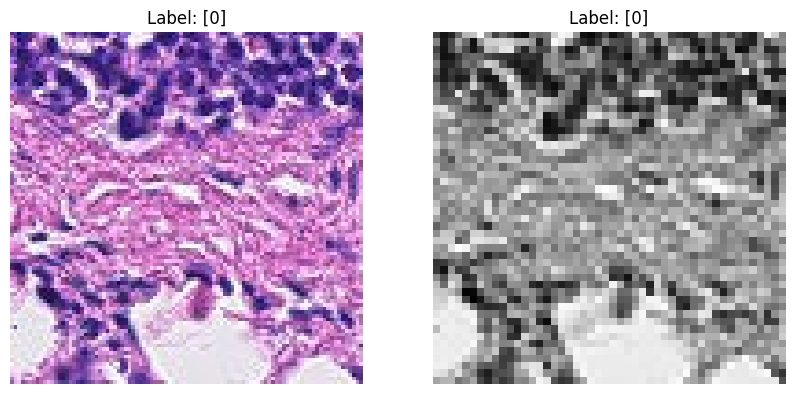

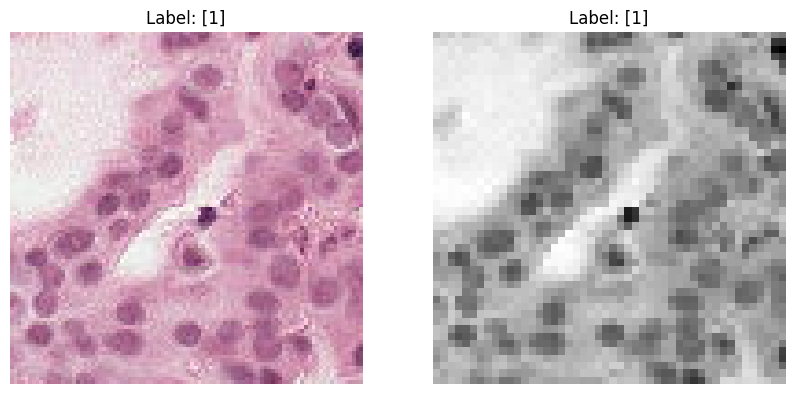

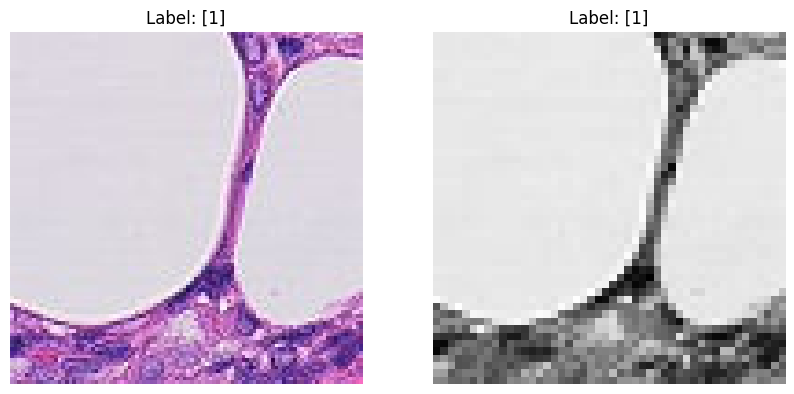

In [ ]:
for i in range(3):
    image_1 = X_train_raw[i]
    label_1 = y_raw[i]
    image_2 = X_train[i]
    label_2 = y_raw[i]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_1, cmap='gray')
    axes[0].set_title(f'Label: {label_1}')
    axes[0].axis('off')

    axes[1].imshow(image_2, cmap='gray')
    axes[1].set_title(f'Label: {label_2}')
    axes[1].axis('off')

    plt.show()

**Create training data for the 3 ensembles:**

In [ ]:
num_ensembles = 3
samples_per_ensemble = X_train.shape[0] // num_ensembles

np.random.seed(42)

for i in range(1, 4):

    indices = np.random.choice(X_train.shape[0], samples_per_ensemble, replace=False)

    X_subset = X_train[indices]
    y_subset = y_raw[indices]

    globals()[f'X_{i}'] = X_subset
    globals()[f'y_{i}'] = y_subset

    X = np.delete(X_train, indices, axis=0)
    y = np.delete(y_raw, indices, axis=0)

**Print the shape of the ensambles:**

In [ ]:
for i in range(1,4):
    X = globals()[f'X_{i}']
    y = globals()[f'y_{i}']
    print(X.shape)
    print(y.shape)

(8738, 48, 48, 1)
(8738, 1)
(8738, 48, 48, 1)
(8738, 1)
(8738, 48, 48, 1)
(8738, 1)


**Model 1:**

In [ ]:
def build_model_1(neurons_per_layer, activation, weight_regularizer, dropout, batch_norm):
    layers = [tf.keras.layers.Flatten(input_shape=(48, 48, 1))]

    for neurons in neurons_per_layer:
        layers.append(tf.keras.layers.Dense(neurons, activation=activation,
                                            kernel_regularizer=weight_regularizer))
        if batch_norm:
            layers.append(tf.keras.layers.BatchNormalization())
        if dropout:
            layers.append(tf.keras.layers.Dropout(0.1))

    layers.append(tf.keras.layers.Dense(2, activation='softmax'))

    model_1 = tf.keras.models.Sequential(layers)
    model_1.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.experimental.Adagrad(0.0001),
        metrics=['sparse_categorical_crossentropy', 'accuracy'],
        )

    return model_1

**Model 2:**

In [ ]:
def build_model_2(neurons_per_layer, activation, weight_regularizer, dropout, batch_norm):
    layers = [tf.keras.layers.Flatten(input_shape=(48, 48, 1))]

    for neurons in neurons_per_layer:
        layers.append(tf.keras.layers.Dense(neurons, activation=activation,
                                            kernel_regularizer=weight_regularizer))
        if batch_norm:
            layers.append(tf.keras.layers.BatchNormalization())
        if dropout:
            layers.append(tf.keras.layers.Dropout(0.5))

    layers.append(tf.keras.layers.Dense(2, activation='softmax'))

    model_2 = tf.keras.models.Sequential(layers)
    model_2.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.experimental.Adagrad(0.00001),
        metrics=['sparse_categorical_crossentropy', 'accuracy'],
        )

    return model_2

**Model 3:**

In [ ]:
def build_model_3(neurons_per_layer, activation, weight_regularizer, dropout, batch_norm):
    layers = [tf.keras.layers.Flatten(input_shape=(48, 48, 1))]

    for neurons in neurons_per_layer:
        layers.append(tf.keras.layers.Dense(neurons, activation=activation,
                                            kernel_regularizer=weight_regularizer))
        if batch_norm:
            layers.append(tf.keras.layers.BatchNormalization())
        if dropout:
            layers.append(tf.keras.layers.Dropout(0.1))

    layers.append(tf.keras.layers.Dense(2, activation='softmax'))

    model_3 = tf.keras.models.Sequential(layers)
    model_3.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.experimental.SGD(0.0001, momentum=0.0001),
        metrics=['sparse_categorical_crossentropy', 'accuracy'],
        )

    return model_3

**Define for all models:**

- optimal stopping
- layers
- validation_split
- epochs

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=25,
                                            restore_best_weights=True)

neurons_per_layer_1 = [65, 128, 128, 128, 64]
neurons_per_layer_2 = [64, 128, 264, 128, 64]
neurons_per_layer_3 = [256, 256, 256]


weight_regularizer_1 = tf.keras.regularizers.L2(0.001)
weight_regularizer_2 = tf.keras.regularizers.L2(0.001)
weight_regularizer_3 = tf.keras.regularizers.L2(0.0050)

validation_split = 0.2

epochs = 1000

**Build the models:**

In [ ]:

model_1 = build_model_1(neurons_per_layer_1, 'relu', weight_regularizer_1, True, True)
model_2 = build_model_2(neurons_per_layer_2, 'relu', weight_regularizer_2, None, True)
model_3 = build_model_3(neurons_per_layer_3, 'relu', weight_regularizer_3, None, True)

model_1.summary()
model_2.summary()
model_3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 65)                149825    
                                                                 
 batch_normalization (Batch  (None, 65)                260       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 65)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8448      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

**Fit the models:**

In [ ]:
history_1 = model_1.fit(
    X_train,
    y_raw,
    epochs=epochs,
    verbose=1,
    validation_split=validation_split,
    callbacks=callback
)

Epoch 1/1000
656/656 [==============================] - 9s 11ms/step - loss: 1.4672 - sparse_categorical_crossentropy: 0.9129 - accuracy: 0.5502 - val_loss: 1.3214 - val_sparse_categorical_crossentropy: 0.7672 - val_accuracy: 0.5844
Epoch 2/1000
656/656 [==============================] - 6s 9ms/step - loss: 1.4102 - sparse_categorical_crossentropy: 0.8560 - accuracy: 0.5703 - val_loss: 1.2967 - val_sparse_categorical_crossentropy: 0.7426 - val_accuracy: 0.6002
Epoch 3/1000
656/656 [==============================] - 7s 11ms/step - loss: 1.3830 - sparse_categorical_crossentropy: 0.8290 - accuracy: 0.5814 - val_loss: 1.2805 - val_sparse_categorical_crossentropy: 0.7266 - val_accuracy: 0.6201
Epoch 4/1000
656/656 [==============================] - 6s 9ms/step - loss: 1.3734 - sparse_categorical_crossentropy: 0.8196 - accuracy: 0.5904 - val_loss: 1.2665 - val_sparse_categorical_crossentropy: 0.7127 - val_accuracy: 0.6302
Epoch 5/1000
656/656 [==============================] - 7s 10ms/step -

In [ ]:
history_2 = model_2.fit(
    X_train,
    y_raw,
    epochs=epochs,
    verbose=1,
    validation_split=validation_split,
    callbacks=callback
)

Epoch 1/1000
656/656 [==============================] - 14s 10ms/step - loss: 1.6580 - sparse_categorical_crossentropy: 1.0171 - accuracy: 0.4834 - val_loss: 1.5908 - val_sparse_categorical_crossentropy: 0.9499 - val_accuracy: 0.5190
Epoch 2/1000
656/656 [==============================] - 7s 10ms/step - loss: 1.6045 - sparse_categorical_crossentropy: 0.9636 - accuracy: 0.5160 - val_loss: 1.5821 - val_sparse_categorical_crossentropy: 0.9411 - val_accuracy: 0.5333
Epoch 3/1000
656/656 [==============================] - 6s 9ms/step - loss: 1.5764 - sparse_categorical_crossentropy: 0.9355 - accuracy: 0.5236 - val_loss: 1.5659 - val_sparse_categorical_crossentropy: 0.9250 - val_accuracy: 0.5417
Epoch 4/1000
656/656 [==============================] - 6s 9ms/step - loss: 1.5624 - sparse_categorical_crossentropy: 0.9215 - accuracy: 0.5292 - val_loss: 1.5571 - val_sparse_categorical_crossentropy: 0.9162 - val_accuracy: 0.5550
Epoch 5/1000
656/656 [==============================] - 7s 10ms/step 

In [ ]:
history_3 = model_3.fit(
    X_train,
    y_raw,
    epochs=epochs,
    verbose=1,
    validation_split=validation_split,
    callbacks=callback
)

**Model performence:**

In [ ]:
for i in range(1,4):
    history_x = globals()[f'history_{i}']
    history_y = globals()[f'history_{i}']

    fig = plt.figure(figsize=plt.figaspect(0.2))


    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history_x.history['loss'], label='Training loss')
    ax.plot(history_y.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over Epochs, Model_{i}')
    plt.legend(loc='upper right')


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history_x.history['accuracy'], label='Training accuracy')
    ax.plot(history_y.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy over Epochs, Model_{i}')
    plt.legend(loc='lower right')

    plt.show()


**Majority vote:**

In [ ]:
df_ensemble = pd.DataFrame()

y_test_hat_1 = model_1.predict(X_test)
y_test_hat_1 = np.argmax(y_test_hat_1, axis=1)

y_test_hat_2 = model_2.predict(X_test)
y_test_hat_2 = np.argmax(y_test_hat_2, axis=1)

y_test_hat_3 = model_3.predict(X_test)
y_test_hat_3 = np.argmax(y_test_hat_3, axis=1)

df_ensemble['model_1'] = y_test_hat_1
df_ensemble['model_2'] = y_test_hat_2
df_ensemble['model_3'] = y_test_hat_3

def calculate_majority(row):
  counts = pd.Series(row).value_counts()
  majority = counts.idxmax()
  return majority

df_ensemble['majority'] = df_ensemble.apply(calculate_majority, axis=1)

print(df_ensemble)

**Final prediction:**

In [ ]:
df_ensemble = pd.DataFrame({
    'Id': range(len(df_ensemble)),
    'Predicted': df_ensemble['majority'].values,
})

path_on_drive = '/content/gdrive/My Drive/Assignment 2/pred.csv'
df_ensemble.to_csv(path_on_drive, index=False)